# Aquabreeding software for simulating aquaculture breeding
Simulation includes the following steps:
- A founder population with {founder_size} individuals is generated.  The chromosome number, size, and crossing-over rates are stored in {chrom}.
- SNPs of the founder population are generated by coalescent simulation.  This version allows only a standard Wright-Fisher model.
- The effect sizes of the SNPs on the phenotype follow a normal distribution with mean 0 and variance {effect_var}.
- A progeny population with {progeny_size} individuals is generated by crossing the individuals of the founder population. The available mating schemes are random mating and factorial mating (1 x 1, 1 x 2, 2 x 2, and full factorial).
- The phenotypic values of the progeny individuals are calculated by summing the true breeding values and the environmental effects, the latter of which follows a normal distribution with mean 0 and variance {residual_var}.
- The breeding values of the progeny individuals are predicted with the numerator relationship matrix.  A restricted maximum likelihood method is applied to predict breeding values and estimate the variance components.
- The founder population of the next generation is generated by selecting the progeny individuals by mass selection or within family selection based on predicted breeding values or phentypic values.
- These processes are repeated until a user is satisfied.

## Parameter setting
The seven parameters have to be set before running the simulation.
- {founder_size}: The number of individuals of a founder population (must be an even number).
- {progeny_size}: The number of individuals of a progeny population (less than 1,000 is recommended).
- {chrom}: tuple(the number of chromosomes, chromosome length (bp), crossing-over rate (cM/Mb)}.
- {n_snp}: The number of SNPs in a founder population.
- {mean_pheno}: Mean phenotypic value of F1 generation.
- {effect_var}: The variance value of the effect sizes of SNPs.
- {residual_var}: The variance value of environmental factor.

## Output
Some statistics of the progeny population are obtained:
- Phenotypic values
- True breeding values
- Predicted breeding values
- Estimated additive genetic and residual variance values
- Inbreeding coefficient (the proportion of identity-by-descent segments)

## To-Do list
- All individuals are hermaphrodites. Sex will be incorporated.
- All SNPs have only additive effects.  Dominance and epistasis will be incorporated.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import aquabreeding as aq

## Random mating and mass selection

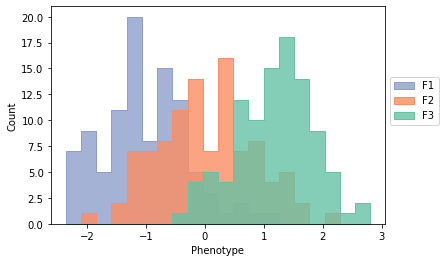

In [90]:
# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
# generate SNPs in the founder
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # random mating
    aqua_bred.random_mating()
    
    # calculating phenotypic and breeding values
    # =====
    # g_blup=True: enable to predict breeding values
    # =====
    aqua_bred.breeding_value_nrm(g_blup=True)
    
    # get phenotype data of the progeny population
    tmp_pheno = aqua_bred.get_phenotype()
    record = pd.DataFrame([tmp_pheno, [f'F{g+1}']*100]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    # =====
    # select_by can be 'bv' (selection based on predicted breeding value), 
    #                  'phenotype' (selection based on phenotypic values), or
    #                  'no' (next founders are selected at random)
    # =====
    aqua_bred.mass_selection(select_by='bv')

sns.histplot(df1, x='Phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], bins=20, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Factorial mating
cross_design in factorial_mating can be
- '1x1' (1 x 1 factorial mating)
- '1x2'
- '2x2'
- 'full' (full factorial)

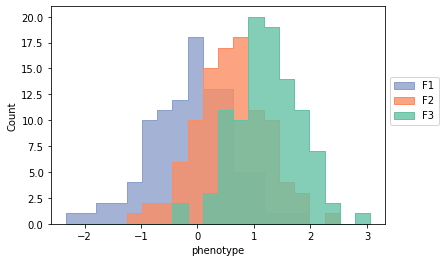

In [91]:
# In the case of 1 x 1 factorial mating

# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # factorial cross
    # =====
    # 1 x 1 factorial mating
    # =====
    aqua_bred.factorial_mating(cross_design='1x1')
    aqua_bred.breeding_value_nrm(g_blup=True)
    
    # get phenotype data
    tmp_pheno = aqua_bred.get_phenotype()
    record = pd.DataFrame([tmp_pheno, [f'F{g+1}']*100]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    aqua_bred.mass_selection(select_by='bv')

sns.histplot(df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], bins=20, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

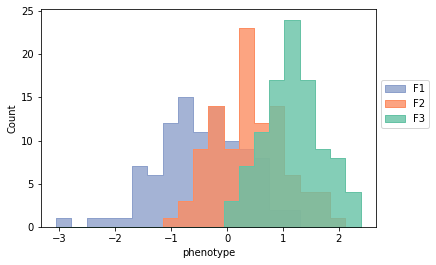

In [93]:
# In the case of full factorial mating

# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # factorial cross
    # =====
    # full factorial
    # =====
    aqua_bred.factorial_mating(cross_design='full')
    aqua_bred.breeding_value_nrm(g_blup=True)
    
    # get phenotype data
    tmp_pheno = aqua_bred.get_phenotype()
    record = pd.DataFrame([tmp_pheno, [f'F{g+1}']*100]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    aqua_bred.mass_selection(select_by='bv')

sns.histplot(df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], bins=20, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Within family selection (i)
To pick up next founders as the effect of inbreeding is minimized

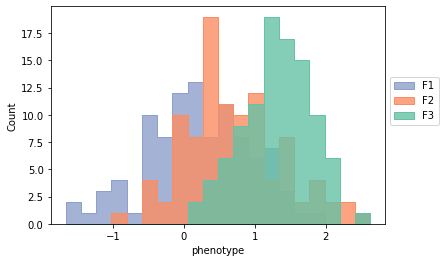

In [94]:
# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # partial diallel cross
    aqua_bred.factorial_mating(cross_design='1x1')
    aqua_bred.breeding_value_nrm(g_blup=True)
    
    # get phenotype data
    record = pd.DataFrame([aqua_bred.pheno_v, [f'F{g+1}']*100]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders by within family selection
    # =====
    # the effect of inbreeding is minimized
    # =====
    aqua_bred.within_family_selection(select_by='bv')

sns.histplot(df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], bins=20, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Within family selection (ii)
Use a new argment, {top_prop}.
The next founders are selected not from all but from the progenies with top {100*top_prop}% of predicted breeding values as the effect of inbreeding is minimized.

If {top_prop} is 1.0 (default), all progenies are used.

If {top_prop} * {progeny_size) == {founder_size}, the result is the same as mass selection.

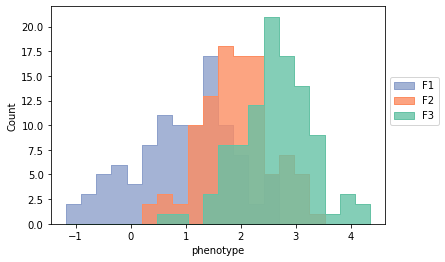

In [96]:
# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # partial diallel cross
    aqua_bred.factorial_mating(cross_design='1x1')
    aqua_bred.breeding_value_nrm(g_blup=True)
    
    # get phenotype data
    record = pd.DataFrame([aqua_bred.pheno_v, [f'F{g+1}']*100]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # =====
    # select next founders by within family selection
    # The next founder is selected from the progenies with top {100*top_prop) percentage of 
    # breeding/phenotypic values
    # if top_prop * progeny_size == founder_size:
    #     the result is the same as by using mass_selection()
    # =====
    aqua_bred.within_family_selection(select_by='bv', top_prop=0.2)

sns.histplot(df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], bins=20, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Phenotypic changes
### Mass selection vs. within family selection

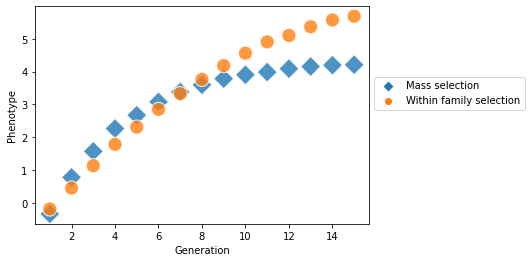

In [68]:
# CAUSION: it takes minutes

# results are stored in pandas DataFrame
cols = ['phenotype', 'generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# mass selection
for i in range(10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding(founder_size=10, 
                                   progeny_size=100, 
                                   chrom=(3, 100_000_000, 1),
                                   n_snp=50,
                                   mean_pheno=0.0,
                                   effect_var=0.04, 
                                   residual_var=0.12)
    aqua_bred.snp_info()

    for g in range(15):  # simulate from F1 to F15
        aqua_bred.factorial_mating(cross_design='1x2')
        aqua_bred.breeding_value_nrm(g_blup=True)
        
        # get phenotype data
        tmp_p = aqua_bred.get_phenotype()
        record = pd.DataFrame([[np.mean (tmp_p), g, 'Mass selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        aqua_bred.mass_selection(select_by='bv')

# within family selection
for i in range(10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding(founder_size=10, 
                                   progeny_size=100, 
                                   chrom=(3, 100_000_000, 1),
                                   n_snp=50,
                                   mean_pheno = 0.0,
                                   effect_var=0.04, 
                                   residual_var=0.12)
    aqua_bred.snp_info()
    
    for g in range(15):  # simulate from F1 to F15
        aqua_bred.factorial_mating(cross_design='1x2')
        aqua_bred.breeding_value_nrm(g_blup=True)
        
        # get phenotype data
        tmp_p = aqua_bred.get_phenotype()
        record = pd.DataFrame([[np.mean (tmp_p), g, 'Within family selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        aqua_bred.within_family_selection(select_by='bv')

cols = ['Generation', 'Phenotype', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range(15):
    for j in ['Mass selection', 'Within family selection']:
        tmp = df1[(df1['generation']==g) & (df1['tag']==j)]
        #print (tmp)
        mean_phe = np.mean(tmp['phenotype'])
        record = pd.DataFrame([[g+1, mean_phe, j]], columns=cols)
        df2 = pd.concat([df2, record], ignore_index=True)
#print (df2)
sns.scatterplot(x="Generation", y="Phenotype", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend(loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Breeding values, phenotypes, and variance components

Estimated additive genetic variance = 0.05930110652886932
Estimated residual variance         = 0.1808472653331253
Heritability                        = 0.2469352845038138


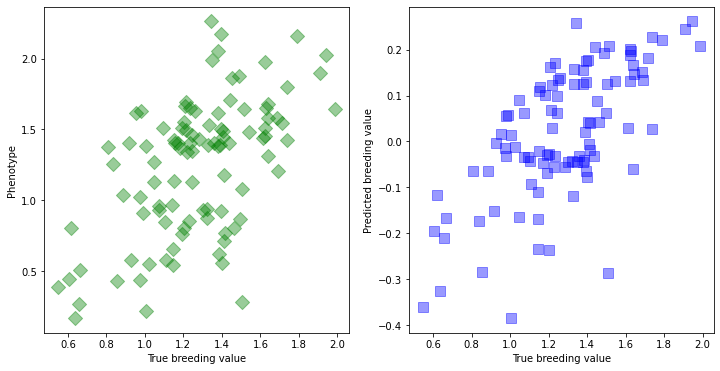

In [78]:
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.008, 
                               residual_var=0.12)
aqua_bred.snp_info()
aqua_bred.random_mating()
aqua_bred.breeding_value_nrm(g_blup=True)

vg = aqua_bred.hat_vg
ve = aqua_bred.hat_ve
print (f'Estimated additive genetic variance = {vg}')
print (f'Estimated residual variance         = {ve}')
print (f'Heritability                        = {vg/(vg+ve)}')

# true breeding value
tbv = aqua_bred.get_true_bv()
# predicted breeding value
pbv = aqua_bred.get_hat_bv()
# phynotypes
phenotype = aqua_bred.get_phenotype()

df = pd.DataFrame([tbv, pbv, phenotype]).transpose ()
df.columns = ['True breeding value', 'Predicted breeding value', 'Phenotype']

#print (pbv)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df.plot.scatter (x='True breeding value', y='Phenotype', c='g', s=100, alpha=0.4, marker='D', ax=axes[0])
df.plot.scatter (x='True breeding value', y='Predicted breeding value', c='b', s=100, alpha=0.4, marker=',', ax=axes[1])
plt.show ()

## Inbreeding coefficient

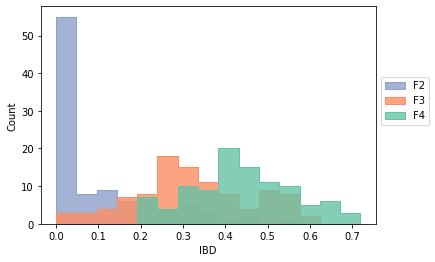

In [82]:
# choose random mating and breeding value-based selection

# results are stored in pandas DataFrame
cols = ['IBD', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
aqua_bred.snp_info()

for g in range(4):  # simulate from F1 to F4
    # random mating
    aqua_bred.random_mating()
    
    # calculating phenotypic and breeding values
    aqua_bred.breeding_value_nrm(g_blup=True)
    
    # get inbreeding coefficient
    if g > 0:  # F1 is discarded because prob. IBD = 0 in all progenies
        ibd = aqua_bred.get_ibd()
        record = pd.DataFrame([ibd, [f'F{g+1}']*100]).transpose ()
        record.columns = cols
        df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    aqua_bred.mass_selection(select_by='bv')

sns.histplot(df1, x='IBD', hue='Generation', hue_order=['F4', 'F3', 'F2'], bins=15, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F2', 'F3', 'F4'], loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## inbreeding coefficient
### mass selection vs. within family selection

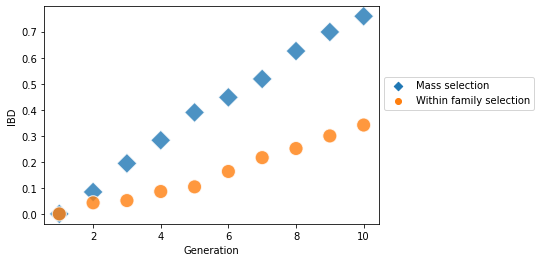

In [86]:
# it takes minutes

# results are stored in pandas DataFrame
cols = ['IBD', 'Generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# select by breeding values
for i in range(5):  # 5 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding(founder_size=10, 
                                   progeny_size=100, 
                                   chrom=(3, 100_000_000, 1),
                                   n_snp=50,
                                   mean_pheno=0.0,
                                   effect_var=0.04, 
                                   residual_var=0.12)
    aqua_bred.snp_info()
    for g in range(10):  # simulate from F1 to F10
        aqua_bred.factorial_mating(cross_design='1x2')
        aqua_bred.breeding_value_nrm(g_blup=True)
        
        # get inbreeding coefficient
        ibd = aqua_bred.get_ibd()
        record = pd.DataFrame([[np.mean (ibd), g, 'Mass selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        # select next founders based on breeding values
        aqua_bred.mass_selection(select_by='bv')

# select by pedigree
for i in range(5):  # 5 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding(founder_size=10, 
                                   progeny_size=100, 
                                   chrom=(3, 100_000_000, 1),
                                   n_snp=50,
                                   mean_pheno=0.0,
                                   effect_var=0.04, 
                                   residual_var=0.12)
    aqua_bred.snp_info()
    for g in range(10):  # simulate from F1 to F10
        aqua_bred.factorial_mating(cross_design='1x2')
        aqua_bred.breeding_value_nrm(g_blup=True)
        
        # get inbreeding coefficient
        ibd = aqua_bred.get_ibd()
        record = pd.DataFrame([[np.mean (ibd), g, 'Within family selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        # select next founders based on pedigree
        aqua_bred.within_family_selection(select_by='bv')

cols = ['Generation', 'IBD', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range(10):
    for j in ['Mass selection', 'Within family selection']:
        tmp = df1[(df1['Generation']==g) & (df1['tag']==j)]
        #print (tmp)
        mean_phe = np.mean(tmp['IBD'])
        record = pd.DataFrame([[g+1, mean_phe, j]], columns=cols)
        df2 = pd.concat ([df2, record], ignore_index=True)
sns.scatterplot(x="Generation", y="IBD", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend(loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Theoretical expectation of inbreeding coefficient with random mating and no selection
$F_{t} = 1 - \left(1 - \frac{1}{2n}\right)^{t-1},$
where $F_{t}$ is inbreeding coefficient at $t$th generation and $n$ is the founder population size

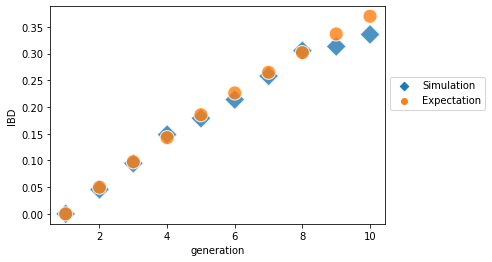

In [89]:
# it takes minutes

# results are stored in pandas DataFrame
cols = ['IBD', 'generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# select by breeding values
for i in range(5):  # 20 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding(founder_size=10, 
                                   progeny_size=100, 
                                   chrom=(3, 100_000_000, 1),
                                   n_snp=50,
                                   mean_pheno=0.0,
                                   effect_var=0.04, 
                                   residual_var=0.12)
    aqua_bred.snp_info()

    for g in range(10):  # simulate from F1 to F10
        aqua_bred.random_mating()
        # g_blup is False because no need to predict breeding values
        aqua_bred.breeding_value_nrm(g_blup=False)
        
        # get inbreeding coefficient
        ibd = aqua_bred.get_ibd()
        record = pd.DataFrame([[np.mean (ibd), g, 'simulation']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        # new founders are selected randomly
        aqua_bred.mass_selection(select_by='no')

cols = ['generation', 'IBD', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range (10):
    tmp = df1[(df1['generation']==g)]
    mean_phe = np.mean(tmp['IBD'])
    record = pd.DataFrame([[g+1, mean_phe, 'Simulation']], columns=cols)
    df2 = pd.concat([df2, record], ignore_index=True)
    
# theoretical expectation
for g in range(10):
    T = g+1
    F = 1.0 - (19.0/20.0)**(T-1)
    record = pd.DataFrame([[T, F, 'Expectation']], columns=cols)
    df2 = pd.concat([df2, record], ignore_index=True)
    
sns.scatterplot(x="generation", y="IBD", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend(loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Check see if recombination works

In [87]:
# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(founder_size=10, 
                               progeny_size=100, 
                               chrom=(3, 100_000_000, 1),
                               n_snp=50,
                               mean_pheno=0.0,
                               effect_var=0.04, 
                               residual_var=0.12)
aqua_bred.snp_info()

# print {n_show} founder individuals
print ('===========')
print ('chromosome = [[start segment, end segment, genotype], [start segment, end segment, genotype],...]')
print ('===========\nIndividual in the founder')
aqua_bred.print_pop(target='founder', n_show=3)

aqua_bred.random_mating()
print ('\n===========\nIndividual in the progeny')
aqua_bred.print_pop(target='progeny', n_show=3)


chromosome = [[start segment, end segment, genotype], [start segment, end segment, genotype],...]
Individual in the founder
Individual ID = 0
  father = -1
  mother = -1
0th chromosome
  paternal
  [[1, 100000000, 0]]
  maternal
  [[1, 100000000, 1]]
1th chromosome
  paternal
  [[1, 100000000, 0]]
  maternal
  [[1, 100000000, 1]]
2th chromosome
  paternal
  [[1, 100000000, 0]]
  maternal
  [[1, 100000000, 1]]
Individual ID = 1
  father = -1
  mother = -1
0th chromosome
  paternal
  [[1, 100000000, 2]]
  maternal
  [[1, 100000000, 3]]
1th chromosome
  paternal
  [[1, 100000000, 2]]
  maternal
  [[1, 100000000, 3]]
2th chromosome
  paternal
  [[1, 100000000, 2]]
  maternal
  [[1, 100000000, 3]]
Individual ID = 2
  father = -1
  mother = -1
0th chromosome
  paternal
  [[1, 100000000, 4]]
  maternal
  [[1, 100000000, 5]]
1th chromosome
  paternal
  [[1, 100000000, 4]]
  maternal
  [[1, 100000000, 5]]
2th chromosome
  paternal
  [[1, 100000000, 4]]
  maternal
  [[1, 100000000, 5]]

Individu